In [1]:
import pandas as pd
import time
pd.set_option('display.max_rows', 26)

import utils.rolling_planning.procedure as rp_proced

import utils.presenter as show
import utils.checker as check

import utils.rescheduling_solver as rssv

from ProductionDaySimulation import ProductionDaySimulation

In [2]:
max_time = 60*60*2 # 2h

## Laden der Produktionsaufträge

In [4]:
file_template = "data/05_{text}.csv"

In [5]:
file = file_template.format(text= "all_jobs")
df_jobs_all = pd.read_csv(file)
df_jobs_all

,Job,Arrival,Deadline,Ready Time,Processing Time,Slack
0,Job_000,0,1845,1440,395,10
1,Job_001,83,2269,1440,510,319
2,Job_002,144,2502,1440,568,494
3,Job_003,197,2812,1440,655,717
4,Job_004,233,2072,1440,393,239
...,...,...,...,...,...,...
375,Job_375,28488,31103,28800,655,1648
376,Job_376,28494,30333,28800,393,1140
377,Job_377,28495,30853,28800,568,1485
378,Job_378,28614,30459,28800,395,1264


In [6]:
df_jobs_all.loc[df_jobs_all['Arrival'].idxmin(), 'Job']

'Job_000'

In [7]:
file = file_template.format(text= "all_ops")
df_ops_all = pd.read_csv(file)
df_ops_all

,Job,Operation,Machine,Processing Time
0,Job_000,0,M0,29
1,Job_000,1,M1,78
2,Job_000,2,M2,9
3,Job_000,3,M3,36
4,Job_000,4,M4,49
...,...,...,...,...
3795,Job_379,5,M9,76
3796,Job_379,6,M5,47
3797,Job_379,7,M3,52
3798,Job_379,8,M4,90


## Laden der Initialisierungsdaten vom Tag 1

In [9]:
day_numb = 1

In [10]:
# Waiting Plan
file = file_template.format(text= f"plan_{day_numb:02d}_waiting")
df_plan_waiting = pd.read_csv(file)
df_plan_waiting

,Job,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,Job_008,9,M8,708,3152,3032,74,3106,-46,0,46
1,Job_009,9,M7,740,3015,2970,45,3015,0,0,0
2,Job_010,9,M3,845,3116,3037,79,3116,0,0,0
3,Job_011,9,M8,894,3338,3264,74,3338,0,0,0
4,Job_012,9,M8,950,3136,3106,30,3136,0,0,0
5,Job_013,9,M7,1123,3267,3242,25,3267,0,0,0
6,Job_014,6,M7,1128,3743,3015,85,3100,-643,0,643
7,Job_014,7,M3,1128,3743,3116,98,3214,-529,0,529
8,Job_014,8,M9,1128,3743,3214,22,3236,-507,0,507
9,Job_014,9,M5,1128,3743,3700,43,3743,0,0,0


In [11]:
# bereits Ausgeführte Operationen
file = file_template.format(text= f"execution_{day_numb:02d}")
df_execution = pd.read_csv(file)
df_execution

,Job,Operation,Arrival,Machine,Start,Simulated Processing Time,Flow time,End
0,Job_000,0,0,M0,1440.00,14.78,1454.78,1454.78
1,Job_000,1,0,M1,1469.00,102.46,1571.46,1571.46
2,Job_000,2,0,M2,1675.88,16.42,1692.30,1692.30
3,Job_000,3,0,M3,1726.87,32.42,1759.29,1759.29
4,Job_000,4,0,M4,1811.99,52.42,1864.41,1864.41
...,...,...,...,...,...,...,...,...
153,Job_018,1,1354,M0,2586.80,8.89,1241.69,2595.69
154,Job_018,2,1354,M2,2595.69,86.96,1328.65,2682.65
155,Job_018,3,1354,M6,2741.37,8.96,1396.33,2750.33
156,Job_018,4,1354,M8,2750.33,123.26,1519.59,2873.59


In [12]:
# für die Vergangenheit geplante Operationen, die nicht geschaft abgearbeitet wurden 
file = file_template.format(text= f"plan_{day_numb:02d}_undone")
df_plan_undone = pd.read_csv(file)
df_plan_undone

,Job,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,Job_011,7,M7,894,3338,2722,89,2811,-527,0,527
1,Job_011,8,M4,894,3338,2811,26,2837,-501,0,501
2,Job_013,5,M9,1123,3267,2599,72,2671,-596,0,596
3,Job_013,6,M0,1123,3267,2704,47,2751,-516,0,516
4,Job_013,7,M6,1123,3267,2751,65,2816,-451,0,451
5,Job_013,8,M4,1123,3267,2837,6,2843,-424,0,424
6,Job_014,3,M4,1128,3743,2704,99,2803,-940,0,940
7,Job_014,4,M6,1128,3743,2816,9,2825,-918,0,918
8,Job_014,5,M8,1128,3743,2834,52,2886,-857,0,857
9,Job_016,4,M8,1135,3493,2744,90,2834,-659,0,659


In [14]:
def print_earliest_job(df_jobs_waiting, info="Info"):
    """
    Gibt den frühesten wartenden Job mit Ankunftszeit und Deadline in einer Zeile formatiert aus.

    Format:
    <Info> frühste: <Jobname>    Arrival: <arrival>    Deadline: <deadline>

    Parameter:
    df_jobs_waiting (pd.DataFrame): DataFrame mit Spalten 'Job', 'Arrival' und 'Deadline'.
    info (str): Informationstext für die Ausgabe.
    """
    if df_jobs_waiting.empty:
        print(f"{info} earliest: Keine wartenden Jobs vorhanden.")
        return

    row = df_jobs_waiting.loc[df_jobs_waiting['Arrival'].idxmin()]
    jobname = row['Job']
    arrival = row['Arrival']
    deadline = row['Deadline']
    print(f"\t{info} earliest {jobname}:\tArrival: {arrival}\tDeadline: {deadline}")


## Rolling Planning ab Tag 2

In [34]:
file_template = "data/06_simple_{text}.csv"

In [17]:
first_start = 2
last_planning_start = 20

day_length = 1440

Day 02: [2880, 4320)
	Current earliest Job_019:	Arrival: 1440	Deadline: 3285
	Undone earliest Job_011:	Arrival: 894	Deadline: 3338
	Wating earliest Job_008:	Arrival: 708	Deadline: 3152

Solver-Status         : OPTIMAL
Objective Value       : 645.00
Best Objective Bound  : 645.00
Laufzeit              : 15.78 Sekunden


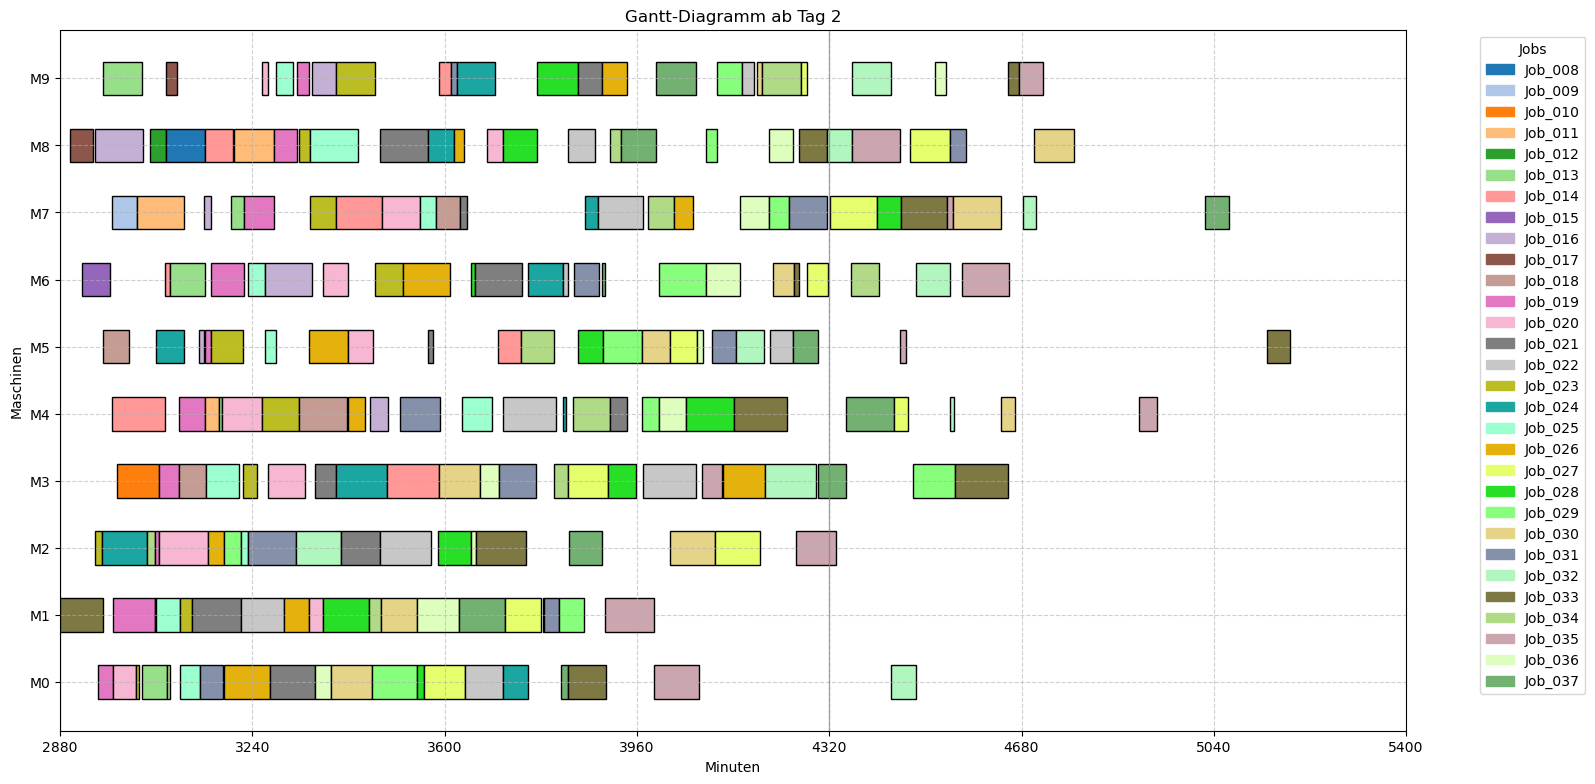

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job
label
<-240           0
-240 - -180     0
-180 - -120     0
-120 - -60      0
-60 - 0         5
0              22
0 - 60          2
60 - 120        1
120 - 180       0
180 - 240       0
>240            0
Name: count, dtype: int32
Number of waiting operations: 28
[48:00:00] Job_033 started on M1
[48:18:00] Job_017 started on M8
[48:40:00] Job_015 started on M6
[48:53:46] Job_017 finished on M8 (after 35 minutes 46 seconds)
[49:05:00] Job_016 started on M8
[49:05:00] Job_023 started on M2
[49:10:00] Job_019 started on M0
[49:18:24] Job_015 finished on M6 (after 38 minutes 24 seconds)
[49:21:00] Job_013 started on M9
[49:21:00] Job_018 started on M5
[49:23:04] Job_023 finished on M2 (after 18 minutes 04 seconds)
[49:23:04] Job_024 started on M2
[49:38:00] Job_009 started on M7
[49:38

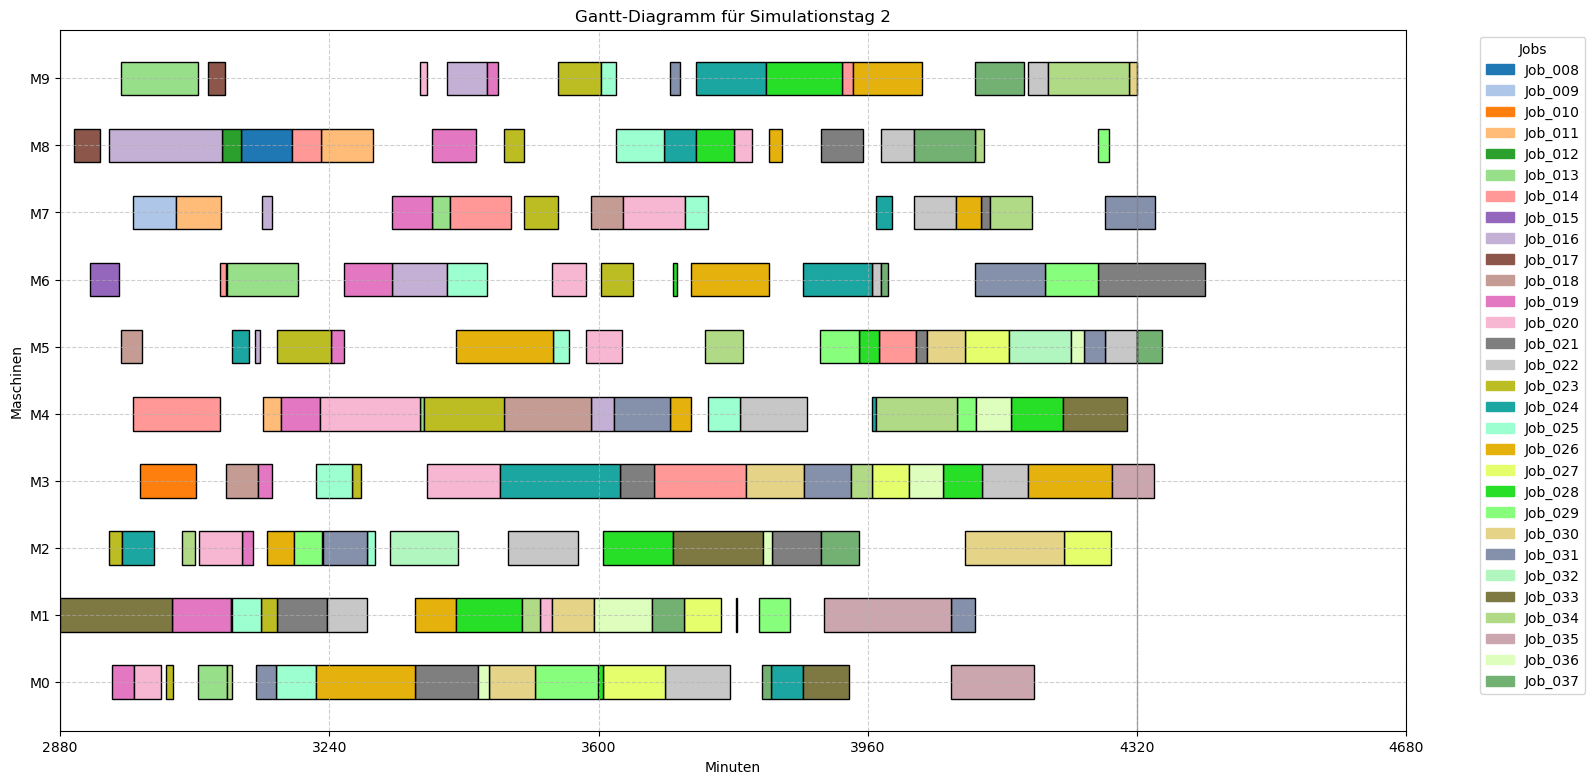

Number of undone operations: 16


In [18]:
for day_numb in range(first_start, last_planning_start + 1):
    day_start = day_length*day_numb 
    day_end = day_start + day_length
    print(f"Day {day_numb:02d}: [{day_start}, {day_end})")

    # ------------------------ I. Operationsvorbereitung ------------------------
    #----------------------------------------------------------------------------
    
    # ---------- a) Filterung nach der aktuellen "Ready Time" ----------
    df_jobs_curr, df_ops_curr = rp_proced.filter_ops_and_jobs_by_ready_time(df_jobs_all, df_ops_all, ready_time = day_start)
    print_earliest_job(df_jobs_curr, "Current")

    # ---------- b) Unerledigte Operationen ----------------------------

    df_ops_undone = df_ops_all.merge(df_plan_undone[["Job", "Operation"]], on=["Job", "Operation"], how="inner")
    df_jobs_undone = df_jobs_all[df_jobs_all["Job"].isin(df_ops_undone["Job"].unique())]
    print_earliest_job(df_jobs_undone, "Undone")
    
    # ---------- c) Wartende Operationen -------------------------------

    df_ops_waiting = df_ops_all.merge(df_plan_waiting[["Job", "Operation"]], on=["Job", "Operation"], how="inner")
    df_jobs_waiting = df_jobs_all[df_jobs_all["Job"].isin(df_plan_waiting["Job"].unique())]
    print_earliest_job(df_jobs_waiting, "Wating")

    # ---------- Zusammenführung ---------------------------------------

    df_ops_curr_combined = pd.concat([df_ops_curr, df_ops_waiting, df_ops_undone], ignore_index=True)
    df_jobs_curr_combined  = pd.concat([df_jobs_curr, df_jobs_waiting, df_jobs_undone], ignore_index=True)
    df_jobs_curr_combined = df_jobs_curr_combined.drop_duplicates(subset="Job", keep="first").sort_values(by="Job").reset_index(drop=True)

    # ------------------------ II. Rescheduling ---------------------------------
    #----------------------------------------------------------------------------

    # Reduktion der bereits ausgeführten Operationen, die im heutigen Plan hineinlaufen
    df_execution_important = df_execution[df_execution["End"] >= day_start]

    # Rescheduling
    df_plan = rssv.solve_cp_jssp_lateness_by_tardiness_and_earliness_with_fixed_ops(df_ops_curr_combined, df_jobs_curr_combined , 
                                                                                    df_execution_important,
                                                                                    w_t = 5,
                                                                                    reschedule_start = day_start, msg=False, 
                                                                                    timeLimit=max_time, gapRel= 0.01)
    df_plan.to_csv(file_template.format(text= f"schedule_{day_numb:02d}"), index=False)

    show.plot_gantt_machines(df_plan, title=f"Gantt-Diagramm ab Tag {day_numb}")
    check.is_machine_conflict_free(df_plan)
    check.is_operation_sequence_correct(df_plan)
    check.is_job_timing_correct(df_plan)
    check.is_start_correct(df_plan)
    
    last_ops = df_plan.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
    print(show.count_column_grouped(last_ops, "Lateness", max_val = 240, steps= 60))

    
    # ------------------------ III. Aufteilung des Schedules --------------------

    df_plan_for_sim = rp_proced.filter_plan_for_today(df_plan, latest_op_start = day_end)
    
    df_plan_waiting = rp_proced.filter_plan_for_future(df_plan, earliest_op_start = day_end)
    waiting_numb = len(df_plan_waiting)
    print(f"Number of waiting operations: {waiting_numb}")


    # ------------------------ IV. Simulation -----------------------------------

    simulation = ProductionDaySimulation(df_plan_for_sim, vc=0.3)
    df_execution, df_plan_undone = simulation.run(start_time = day_start, end_time=day_end)

    if not df_execution.empty:
        show.plot_gantt_machines(df_execution, title=f"Gantt-Diagramm für Simulationstag {day_numb}", duration_column="Simulated Processing Time")
    else:
        print(f"Nothing executed on day {day_numb}")

    undone_numb = len(df_plan_undone)
    print(f"Number of undone operations: {undone_numb}")
    print("_"*79)